In [1]:
from keras.applications import inception_v3
from keras import backend as K
K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights = 'imagenet' , include_top = False)

Using TensorFlow backend.


In [2]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [3]:
layer_contributions = {
    'mixed2':0.2,
    'mixed3':3.,
    'mixed4':2.,
    'mixed5':1.5
}

In [4]:
layer_dictionary = {layer.name : layer for layer in model.layers}

In [5]:
loss = K.variable(0.0)
for lname in layer_contributions:
    coeff = layer_contributions[lname]
    activation = layer_dictionary[lname].output
    
    scaling = K.prod(K.cast(K.shape(activation),'float32'))
    loss = loss + coeff*K.sum(K.square(activation[:,2:-2,2:-2,:]))/scaling

In [6]:
deepdream = model.input

grads = K.gradients(loss,deepdream)[0]

grads /= K.maximum( K.mean( K.abs(grads) ), 1e-7 ) 

outputs = [ loss , grads ]
fetch_loss_and_grads = K.function( [deepdream] , outputs )

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value,grad_values

def gradient_ascent(x , iters , step , max_loss = None):
    for i in range(iters):
        loss_value,grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print(f" Loss value at {i} is {loss_value} ")
        x += step*grad_values
    return x    



In [7]:
import scipy
import scipy.misc
from keras.preprocessing import image
import imageio

def resize_img(img,size):
    img = np.copy(img)
    factors = (
                1,
                float(size[0])/img.shape[1],
                float(size[1])/img.shape[2],
                1
                )
    return scipy.ndimage.zoom(img,factors,order = 1)

def save_img(img,fname):
    pil_img = deprocess_image(np.copy(img))
#     scipy.misc.imsave(fname,pil_img)
    imageio.imwrite(fname, pil_img)
    
def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis = 0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3,x.shape[2],x.shape[3]))
        x = x.transpose((1,2,0))
    else:
        x = x.reshape((x.shape[1],x.shape[2],3))
    x /= 2
    x += 0.5
    x *= 255
    x = np.clip(x,0,255).astype('uint8')
    return x

In [10]:
import os
currdir = os.getcwd()

os.listdir(currdir)

['.ipynb_checkpoints',
 '047.jpg',
 '048.jpg',
 '1262.jpg',
 '1355.jpg',
 '740_1375_compressed_Chicago_Crimes_2001_to_2004.csv.zip',
 '740_1375_compressed_Chicago_Crimes_2005_to_2007.csv.zip',
 '740_1375_compressed_Chicago_Crimes_2008_to_2011.csv.zip',
 '894d5a756219106010319ac9e3555d75.jpg',
 'aclImdb',
 'aclImdb.zip',
 'Avocado Price Prediction.ipynb',
 'avocado.csv',
 'CaliforniPricePrediction.ipynb',
 'Car Price Prediction.ipynb',
 'Car_Purchasing_Data.csv',
 'CharacterLevelLSTMTextGeneration.ipynb',
 'CharacterLevelLSTMTextGeneration2.ipynb',
 'ChicagoCrimeRatePredictions.ipynb',
 'Chicago_Crimes_2001_to_2004.csv',
 'Chicago_Crimes_2005_to_2007.csv',
 'Chicago_Crimes_2008_to_2011.csv',
 'cifar-10-python.tar.gz',
 'CIFAR10.ipynb',
 'cifar10_model_1.h5',
 'Codalab',
 'datasets',
 'EmailForecasting.ipynb',
 'emails.csv',
 'glove.6B.zip',
 'gloveDir',
 'Hackerearth',
 'ImplementingDeepDream.ipynb',
 'jena_climate_2009_2016.csv',
 'jena_climate_2009_2016.csv.zip',
 'Kaggle',
 'MNIST Da

In [18]:
base_image_path = os.path.join(currdir,'1355.jpg')

In [19]:
import numpy as np
step = 0.01
num_octave = 3
octave_scale = 1.4
iters = 20
max_loss = 10.

img = preprocess_image(base_image_path)
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1,num_octave):
    shape = tuple([int(dim/(octave_scale)**i) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img,successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape ',shape)
    img = resize_img(img,shape)
    img = gradient_ascent(img,iters,step,max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img,shape)
    same_size_original = resize_img(original_img,shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img += lost_detail
    shrunk_original_img = resize_img(original_img,shape)
    save_img(img,fname = 'dream_at_scale_'+str(shape) + '.png')
    
save_img(img,fname = 'final_dream.png')
# import numpy as np

# # Playing with these hyperparameters will also allow you to achieve new effects

# step = 0.01  # Gradient ascent step size
# num_octave = 3  # Number of scales at which to run gradient ascent
# octave_scale = 1.4  # Size ratio between scales
# iterations = 20  # Number of ascent steps per scale

# # If our loss gets larger than 10,
# # we will interrupt the gradient ascent process, to avoid ugly artifacts
# max_loss = 10.

# # Fill this to the path to the image you want to use

# # Load the image into a Numpy array
# img = preprocess_image(base_image_path)

# # We prepare a list of shape tuples
# # defining the different scales at which we will run gradient ascent
# original_shape = img.shape[1:3]
# successive_shapes = [original_shape]
# for i in range(1, num_octave):
#     shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
#     successive_shapes.append(shape)

# # Reverse list of shapes, so that they are in increasing order
# successive_shapes = successive_shapes[::-1]

# # Resize the Numpy array of the image to our smallest scale
# original_img = np.copy(img)
# shrunk_original_img = resize_img(img, successive_shapes[0])

# for shape in successive_shapes:
#     print('Processing image shape', shape)
#     img = resize_img(img, shape)
#     img = gradient_ascent(img,
#                           iterations,
#                           step,
#                           max_loss)
#     upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
#     same_size_original = resize_img(original_img, shape)
#     lost_detail = same_size_original - upscaled_shrunk_original_img

#     img += lost_detail
#     shrunk_original_img = resize_img(original_img, shape)
#     save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

# save_img(img, fname='final_dream.png')

Processing image shape  (244, 183)
 Loss value at 0 is 1.8607988357543945 
 Loss value at 1 is 2.364619731903076 
 Loss value at 2 is 3.161116600036621 
 Loss value at 3 is 3.767132520675659 
 Loss value at 4 is 4.366612434387207 
 Loss value at 5 is 4.904202461242676 
 Loss value at 6 is 5.37113618850708 
 Loss value at 7 is 5.883158206939697 
 Loss value at 8 is 6.358800888061523 
 Loss value at 9 is 6.784440040588379 
 Loss value at 10 is 7.179477214813232 
 Loss value at 11 is 7.569149017333984 
 Loss value at 12 is 7.906272888183594 
 Loss value at 13 is 8.300115585327148 
 Loss value at 14 is 8.68493366241455 
 Loss value at 15 is 9.06418228149414 
 Loss value at 16 is 9.510379791259766 
 Loss value at 17 is 9.804475784301758 
Processing image shape  (342, 257)
 Loss value at 0 is 2.9567482471466064 
 Loss value at 1 is 4.417728900909424 
 Loss value at 2 is 5.620589256286621 
 Loss value at 3 is 6.525821685791016 
 Loss value at 4 is 7.340308666229248 
 Loss value at 5 is 8.1051

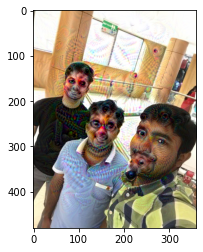

In [20]:
from matplotlib import pyplot as plt
plt.imshow(deprocess_image(np.copy(img)))